<a href="https://colab.research.google.com/github/umaty91/Think-Stats/blob/master/Tutorial_5_Deep_Q_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tutorial 5 - DQN

Please follow this tutorial to understand the structure (code) of DQN algorithm.


### References:

Please follow [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) for the original publication as well as the psuedocode. Watch Prof. Ravi's lectures on moodle or nptel for further understanding of the core concepts. Contact the TAs for further resources if needed.


In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


^C
^C


In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gymnasium as gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [ ]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''
env = gym.make('CartPole-v1')

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, _ , info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")


4
2
0
----
(array([-0.02817373,  0.04625758,  0.00447643, -0.02708739], dtype=float32), {})
----
1
----
[-0.02724857  0.24131505  0.00393468 -0.3183546 ]
1.0
False
{}
----


## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components.

### Q-Network:
The neural network used as a function approximator is defined below

In [ ]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer:

Recall why we use such a technique.

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Tutorial Agent Code:


In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

### Here, we present the DQN algorithm code.

In [ ]:
import matplotlib.pyplot as plt

Episode 100	Average Score: 39.60
Episode 200	Average Score: 147.29
Episode 300	Average Score: 112.16
Episode 400	Average Score: 85.11
Episode 500	Average Score: 14.00
Episode 600	Average Score: 24.07
Episode 700	Average Score: 16.28
Episode 800	Average Score: 15.51
Episode 900	Average Score: 18.20
Episode 1000	Average Score: 33.02
Episode 1100	Average Score: 13.05
Episode 1200	Average Score: 13.35
Episode 1300	Average Score: 13.89
Episode 1400	Average Score: 14.97
Episode 1500	Average Score: 15.75
Episode 1600	Average Score: 22.62
Episode 1700	Average Score: 69.65
Episode 1800	Average Score: 78.25
Episode 1900	Average Score: 78.54
Episode 2000	Average Score: 82.37
Episode 2100	Average Score: 115.33
Episode 2200	Average Score: 106.99
Episode 2300	Average Score: 123.99
Episode 2400	Average Score: 133.26
Episode 2426	Average Score: 199.55
Environment solved in 2426 episodes!	Average Score: 199.55
0:08:17.168264


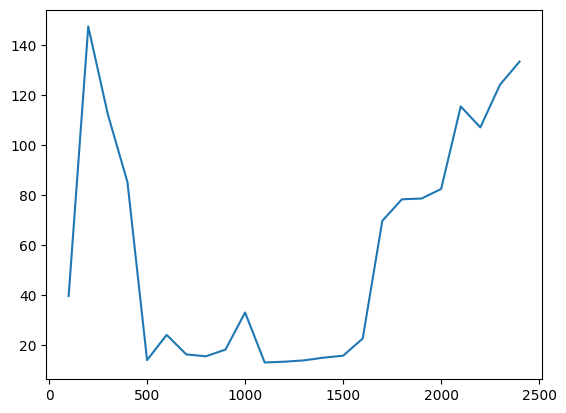

In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start
    ''' initialize epsilon '''
    score_avg = {}

    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ , _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           score_avg[i_episode] = np.mean(scores_window)
        if np.mean(scores_window)>=195.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    x, y = zip(*score_avg.items())
    plt.plot(x,y, label='Average score vs. Episode')
    return True

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
dqn()

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

### **Task 1a**  
Understand the core of the algorithm, follow the flow of data. Identify the exploration strategy used.
### **Task 1b**
Out of the two exploration strategies discussed in class ($ϵ$-greedy & Softmax). Implement the strategy that's not used here.
### **Task 1c**
How fast does the agent 'solve' the environment in terms of the number of episodes?
(Cartpole-v1 defines "solving" as getting average reward of 195.0 over 100 consecutive trials)

How 'well' does the agent learn? (reward plot?) The above two are some 'evaluation metrics' you can use to comment on the performance of an algorithm.

Please compare DQN (using $\epsilon$-greedy) with DQN (using softmax). Think along the lines of 'no. of episodes', 'reward plots', 'compute time', etc. and add a few comments.



#### **Submission Steps**

#### Task 1: Add a text cell with the answer.

#### Task 2: Add a code cell below task 1 solution and use 'Tutorial Agent Code' to build your new agent (with a different exploration strategy).

#### Task 3: Add a code cell below task 2 solution running both the agents to solve the CartPole v-1 environment and add a new text cell below it with your inferences.

ANSWERS:

Task 1.a) Action selection with Exploration - Epsilon decaying greedy for early exploration and as the agent gathers experience, starts exploiting.

Experience Replay: Experience replay helps in decorrelating the sequential experiences by storing them in a replay memory buffer(memory). This memory buffer is randomly sampled during the network update to break the temporal dependencies and stabilize learning by avoiding catastrophic forgetting.

Target Network: Use a separate target network(qnetwork_target) with the same architecture as the main network(qnetwork_local) to stabilize the learning process. Periodically update the target network by copying the weights from the main network.

Q-Learning Update: Sample mini-batches of experiences from the replay memory to update the neural network weights. The update is performed using the loss function(mse loss between target and local network) derived from the Bellman equation, which minimizes the discrepancy between the predicted and target action-values.

In [ ]:
from scipy.special import softmax
seed = 42
rg = np.random.RandomState(seed)

class TutorialAgent_SoftMax():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present)
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))'''

        ''' Softmax exploration action selection'''
        return rg.choice(self.action_size, p = softmax(action_values.cpu().data.numpy()[0]))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

Episode 100	Average Score: 107.47
Episode 200	Average Score: 79.24
Episode 300	Average Score: 54.83
Episode 400	Average Score: 98.77
Episode 500	Average Score: 124.21
Episode 600	Average Score: 80.90
Episode 700	Average Score: 103.61
Episode 762	Average Score: 197.30
Environment solved in 762 episodes!	Average Score: 197.30
0:04:38.471237


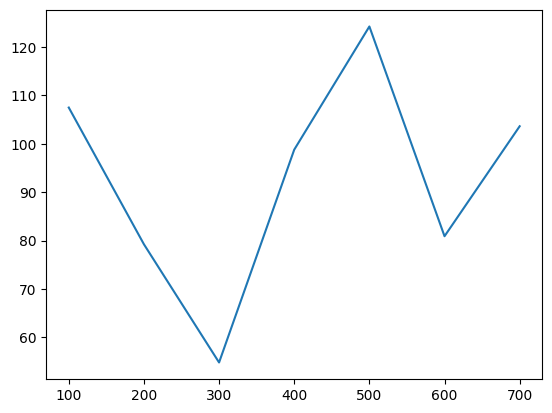

In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, tau_start=0.50, tau_end=0.01, tau_decay=0.995):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    tau = tau_start
    ''' initialize epsilon '''
    score_avg = {}

    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, tau)
            next_state, reward, done, _ , _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)

        tau = max(tau_end, tau_decay*tau)
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           score_avg[i_episode] = np.mean(scores_window)
        if np.mean(scores_window)>=195.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    x, y = zip(*score_avg.items())
    plt.plot(x,y, label='Average score vs. Episode')
    return True

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent_SoftMax(state_size=state_shape,action_size = action_shape,seed = 0)
dqn()

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

**Metric = DQN (using  ϵ -greedy) : DQN (using softmax). **

'no. of episodes' = 2426 : 762

'average reward' = 199.55 : 197.3

'compute time' = 0:08:17.168264 : 0:04:38.471237

Softmax exploration for lower tau values is converging faster than epsilon greedy. Epsilon greedy achieves slightly higher reward than softmax DQN.

In [ ]:
!pip install nbconvert

In [ ]:
!apt install -y pandoc texlive -xetex

E: Command line option 'x' [from -xetex] is not understood in combination with the other options.


In [ ]:
!jupyter nbconvert --to pdf ./DA6400_Tutorial_5_DQN.ipynb

[NbConvertApp] WARNING | pattern './DA6400_Tutorial_5_DQN.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
-